In [5]:
using CSV, DataFrames, Random, LinearAlgebra, Distances, Distributions, SpecialFunctions, Plots

#Necessary functions

function alpha_gt(x::Float64, y::Float64, omega::Float64, t::Float64)
    
        al=0
        if(abs(x-y)<t) 
             al=exp(-((x-y)^2)/(omega^2))
             #denom=(pi/2)*(erf(t/omega)-erf(-t/omega))
             #al/=denom
        end
        return al
    end
    
    function alpha_tri(x::Float64, y::Float64, slope::Float64, t::Float64)
        
        alpha=0.0
        
        if ( abs(x-y) < t) 
            
            alpha=1- (slope*abs(x-y))
            
        end
            
        return max(0,alpha)
        
    end
        
    
    function mc_gt(x::Vector{Float64},y::Vector{Float64},omega::Float64, t::Float64)
        
        res=0
        
        for i in 1:10^6
            
            x1=sample(x)
            y1=sample(y)
            
            res+=(mean(x)-x1)*alpha_gt(x1,y1,omega,t)
            
        end
        return res/(10^6)
        
    end
    
    function mc_tri(x::Vector{Float64},y::Vector{Float64},slope::Float64, t::Float64)
        
        res=0
        
        for i in 1:10^6
            
            x1=sample(x)
            y1=sample(y)
            
            res+=(mean(x)-x1)*alpha_tri(x1,y1,slope,t)
            
        end
        return res/(10^6)
        
    end
    
    function qgprob(n::Int64)
    
        #All possible phenotypes
        pheno= collect(1:(2*n+1)) ./ (2*n+1)
        nt=length(pheno)
    
        G=zeros(Float64,n+1,n+1,n+1)
    
        for i in 0:n, j in 0:i, k in max(0,(i+j-n)):min(n,(i+j))
                    m=collect(0:min(j,k,i+j-k))
                    G[1+i,1+j,1+k]=sum(pdf.(Hypergeometric(i,n-i,j),m).*pdf.(Binomial.(i+j .- (2 .* m)),k .- m))
        end
    
        for k in 0:n
            G[:,:,1+k]=G[:,:,1+k]+transpose(G[:,:,1+k])
            for i1 in 0:n
                G[i1+1,i1+1,k+1] /= 2
            end
        end
    
        ind_haplR=zeros(Float64,2*n+1, 2*n+1)
    
        for k in 0:n
            for i in 0:n
                 ind_haplR[1+i,1+k] = G[1+i,1,1+k]
                for j in 0:n
                    ind_haplR[1+j+n,1+k]=G[1+n,1+j,1+k]
                end
            end
        end
    
        R=zeros(Float64,nt,nt,nt)
    
        for i in 0:(2*n), j in 0:(2*n), q in 0:(2*n)
             R[1+i,1+j,1+q]= sum(ind_haplR[1+i,1 .+ (0:q)] .*
                                 ind_haplR[1+j,1+q .- (0:q)])
        end
    
        return R
    end
    
    
    
    function single_sim(r,K,a1,A,R,Ng0,Npop)
        
            Np0=Ng0 .*Npop
            Ngen=deepcopy(Ng0)
            Np=deepcopy(Np0)
        
            dat=zeros(Float64,1000,nsp,nt)
            
            #Start the simulation
            for m in 1:1000
        
                #Determine the extinct species
                Np[findall(sum(Np,dims=2) .< 10),:] .= 0
                Ngen[findall(sum(Np,dims=2) .==0),:] .= 0
    
                if all(sum(Np,dims=2) ==0) 
                    break
                else
    
                    newgen=zeros(Float64,nsp,nt)
    
                    #Reproduction event
                    for i in findall(!iszero,sum(eachcol(Ngen)))
    
                        probs=Ngen[i,:]*Ngen[i,:]'
                    
                        newgen[i,:]=[sum(probs.*R[:,:,j]) for j in 1:nt]
                    
                        newgen[i,:] ./= sum(newgen[i,:])
                        
                    end
    
                    newp=newgen .* sum(Np,dims=2)
    
                    #Selection event
                
                    if size(A)[1]>1
    
                        for i in 1:size(newp)[1]

                            comps=[sum((a1*A[j,:]) .* newp[1:end .!=i,:]') + sum(A[j,:] .* newp[i,:]) for j in 1:nt]
                        
                            Np[i,:] += newp[i,:] .* r[i] .* (1 .-(comps ./K[i]))

                        end
                    
                    end
    
                    Np[findall(Np .<1)] .= 0
                    Ngen= Np ./ sum(Np,dims=2)
                    Ngen[isnan.(Ngen)].=0
                end
                
            dat[m,:,:]=Np
                
            end
        
        return dat
        
    end
    
 function single_sim1(r,K,a1,A,R,Ng0,Npop)
        
            Np0=Ng0 .*Npop
            Ngen=deepcopy(Ng0)
            Np=deepcopy(Np0)
        
            dat=zeros(Float64,1001,nsp,nt)
    
            dat[1,:,:]=Np
            
            #Start the simulation
            for m in 2:1001
        
                #Determine the extinct species
                Np[findall(sum(Np,dims=2) .< 10),:] .= 0
                Ngen[findall(sum(Np,dims=2) .==0),:] .= 0
    
                if all(sum(Np,dims=2) ==0) 
                    break
                else
    
                    newgen=zeros(Float64,nsp,nt)
    
                    #Reproduction event
                    for i in findall(!iszero,sum(eachcol(Ngen)))
    
                        probs=Ngen[i,:]*Ngen[i,:]'
                    
                        newgen[i,:]=[sum(probs.*R[:,:,j]) for j in 1:nt]
                    
                        newgen[i,:] ./= sum(newgen[i,:])
                        
                    end
    
                    newp=newgen .* sum(Np,dims=2)
    
                    #Selection event
                
                    if size(A)[1]>1
    
                        for i in 1:size(newp)[1]
                    
                            #This is where we have to make big choices!! a)Whether or not to make conspecific individuals compete the 
                            #same way as heterospecifics. b) Interprete the meaning of carrying capacity. Do different numbers
                            #apply for different species? If yes, what is the interpretation of this type of competition?
                           
                            #Reduction in growth rate due to intraspecific competition (not trait-dependent!). The carrying capacity
                            #here is assumed to be the same for all species.

                            rdash=r[i] * (1 -(sum(newp[i,:])/5000))
                        
                            #Impact of interspecific competition

                            comps=[(a1.*sum((A[j,:]) .* newp[1:end .!=i,:]')) for j in 1:nt]
                        
                            Np[i,:] += newp[i,:] .* rdash .* (1 .-(comps ./K))
                        
                        end
                    
                    end
    
                    Np[findall(Np .<1)] .= 0
                    Ngen= Np ./ sum(Np,dims=2)
                    Ngen[isnan.(Ngen)].=0
                end
                
            dat[m,:,:]=Np
                
            end
        
        return dat
        
    end
    
    
#Blanket function to create trait and population trajectories
function doplots(r,K,a1,A,R,Ng0,Npop)
        
        res=single_sim1(r,K,a1,Ag,R,Ng0,1000.0)

        pops=zeros(Float64,1000,nsp)
        trmeans=zeros(Float64,1000,nsp)

        for i in 1:nsp

        pops[:,i]=[sum(res[x,i,:]) for x in 1:1000]
        trmeans[:,i]=[sum(res[x,i,:] .* geno)/sum(res[x,i,:])  for x in 1:1000]

        end

        p1=plot(pops[:,1],legend = false)
        for i1 in 2:nsp
        plot!(pops[:,i1],legend = false)
        end

        p2=plot(trmeans[:,1],legend = false)
        for i2 in 2:nsp
        plot!(trmeans[:,i2],legend = false)
        end

        plot(p1,p2)
        
end
        
        

single_sim1 (generic function with 1 method)

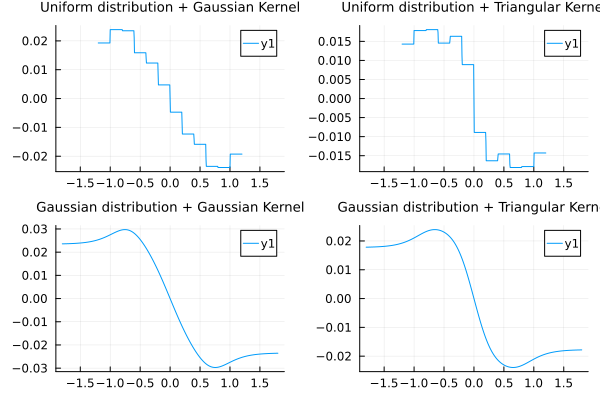

In [8]:
#Plot beta functions for different parameter combinations

########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

n=5
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
    omega=1.0
    slope=0.75
    t=1.0
    a1=0.1

#Set the mean trait value for species no. 2
means=collect(-1.8:0.005:1.8)

#Pre-calculate coefficients of competition between pairs of phenotypes

A0g=zeros(Float64,nt,nt)
A0t=zeros(Float64,nt,nt)


for i1 in 1:nt, i2 in 1:nt
    
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

A1t=0.5 .* A0t

A1g= 0.5 .*A0g

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas2,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end

p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9))

plot(p1,p4,p2,p3, layout = (2,2))

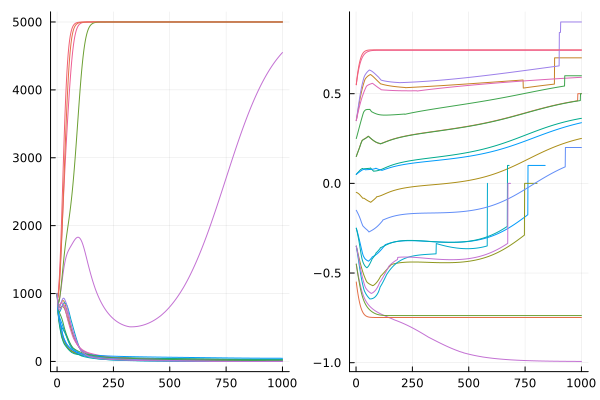

In [9]:
#Long term simulations for multispecies competition

#Sample initial conditions

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=0.75
    t=1.0
    a1=0.1

    #Demographic parameters
    #intrinsic growth rate, assumed to be specific to each species,not the phenotypes.
    r=abs.(rand(Uniform(0.2,0.3),nsp))

    #Carrying capacity, however, is solely the function of the phenotype, not the species.
    #The total carrying capacity of the environment is held constant and split across different phenotypes.
    #As a simplifying first step, the carrying capacity is split evenly across all possible phenotypes.

    K=20000 ./ (nt .* ones(Int64,nt))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    Ag=zeros(Float64,nt,nt)
    At=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        Ag[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        At[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    #A1t=a1 .* A0t

    #A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.6,0.6),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.4,rands[i]+0.4),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)


    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    Np0=Ng0 .*1000
    Ngen=deepcopy(Ng0)
    Np=deepcopy(Np0);

res=single_sim1(r,K,a1,Ag,R,Ng0,1000.0)

pops=zeros(Float64,1000,nsp)
trmeans=zeros(Float64,1000,nsp)

for i in 1:nsp

    pops[:,i]=[sum(res[x,i,:]) for x in 1:1000]
    trmeans[:,i]=[sum(res[x,i,:] .* geno)/sum(res[x,i,:])  for x in 1:1000]
    
end

p1=plot(pops[:,1],legend = false)
for i1 in 2:nsp
    plot!(pops[:,i1],legend = false)
end

p2=plot(trmeans[:,1],legend = false)
for i2 in 2:nsp
    plot!(trmeans[:,i2],legend = false)
end

plot(p1,p2)

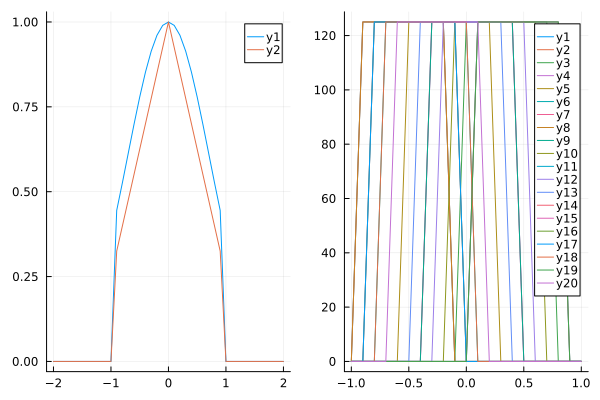

In [7]:
#plot kernels

xs=-2:0.1:2

ygt=[alpha_gt(0.0,x,omega,t) for x in xs]

ytri=[alpha_tri(0.0,x,slope,t) for x in xs]

p1=plot(xs,ygt)
plot!(xs,ytri)

#Plot initial trait distributions

p2=plot(geno,Np[1,:])

for i in 2:nsp
    
    plot!(geno,Np[i,:])
    
end

plot(p1,p2) 

In [ ]:
anim=@animate for i ∈ 1:1000
    
    plot(geno,res[i,1,:])
    for j in 2:nsp
        plot!(geno,res[i,j,:])
    end
end

gif(anim,fps=5)

In [ ]:

anim=@animate for i ∈ 1:1000
    
    res=dat[i,:,:]
    p1=plot(geno,res[1,:])
    [plot!(geno,res[j,:]) for j in 2:20]
    plot(p1)
end
#gif(anim,fps=5)

In [ ]:
########################################################################################################
#Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
########################################################################################################

n=15
geno= collect(range(-1.0,stop=1.0,length=2*n+1))
nt=length(geno)

#Parameters related to the competition kernels
omega=1.0
slope=0.63
t=1.0
a1=0.5

#Set the mean trait value for species no. 2
means=collect(-1.8:0.005:1.8)

#Pre-calculate coefficients of competition between pairs of phenotypes

A0g=zeros(Float64,nt,nt)
A0t=zeros(Float64,nt,nt)


for i1 in 1:nt, i2 in 1:nt
    
    A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
    A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    
end

A1t=0.5 .* A0t

A1g= 0.5 .*A0g

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas1=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas1[i]=sum(newfreq .* geno)
    
end


p1=plot(means,betas1,title="Uniform distribution + Gaussian Kernel",titlefont=font(9))


########################################################################################################
#Case 2: Gaussian distributed traits + truncated gaussian comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas2=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1g[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas2[i]=sum(newfreq .* geno)
    
end

p2=plot(means,betas2,title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

########################################################################################################
#Case 3: Gaussian distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(truncated(Normal(0.0,0.2),-1.0,1.0),geno)
    
N1=N1 ./ sum(N1)

betas3=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(truncated(Normal(means[i],0.2),-1.0,1.0),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas3[i]=sum(newfreq .* geno)
    
end

p3=plot(means,betas3,title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

########################################################################################################
#Case 4: Uniformly distributed traits + Triangular comp. kernel
########################################################################################################

#Assign probabilities for all phenotypes of spp. 1 and assume that mean trait value for species 1 is 0.0.

N1=pdf.(Uniform(-0.2,0.2),geno)
    
N1=N1 ./ sum(N1)

betas4=zeros(Float64,length(means))

for i in 1:length(means)
    
    #Create a trait distribution around the mean trait value for spp. 2

    N2=pdf.(Uniform(means[i]-0.2,means[i]+0.2),geno)

    N2= N2 ./ sum(N2)

    N1n= map(x-> sum(A1t[x,:].*N2),1:length(N1))
    
    newfreq=(1 .- N1n).*N1

    newfreq=newfreq ./ sum(newfreq)
        
    betas4[i]=sum(newfreq .* geno)
    
end

p4=plot(means,betas4,title="Uniform distribution + Triangular Kernel",titlefont=font(9))

plot(p1,p4,p2,p3, layout = (2,2))

In [ ]:
#Run the long term simulations with different parameter combinations

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=1.0
    t=1.0
    a1=0.15
    r=abs.(rand(Uniform(1.0,1.1),nsp))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    A0g=zeros(Float64,nt,nt)
    A0t=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    A1t=a1 .* A0t

    A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.8,0.8),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.2,rands[i]+0.2),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)



    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1g ./10000

    A0=A0g ./10000

    #single_sim(r,A1,A0,R, Ng0, Npop)

    result=single_sim1(r,nsp,A1,A0,R,Ng0,1000)

In [ ]:
#Run the long term simulations with different parameter combinations

  nsp=20
  n=10

    #traits range between -1 and 1.
    geno= collect(range(-1.0,stop=1.0,length=2*n+1))
    nt=length(geno)

    #Parameters related to the competition kernels
    omega=1.0
    slope=1.0
    t=1.0
    a1=0.15
    r=abs.(rand(Uniform(1.0,1.1),nsp))

    #Pre-calculate coefficients of competition between pairs of phenotypes

    A0g=zeros(Float64,nt,nt)
    A0t=zeros(Float64,nt,nt)

    for i1 in 1:nt, i2 in 1:nt

        A0g[i1,i2]=alpha_gt(geno[i1],geno[i2],omega,t)
        A0t[i1,i2]=alpha_tri(geno[i1],geno[i2],slope,t)
    end

    A1t=a1 .* A0t

    A1g= a1 .*A0g

    #Precalculate R, the outcomes of mating between each of pair of phenotypes
    R=qgprob(n)

    #Starting populations

    rands=rand(Uniform(-0.8,0.8),nsp)

    N_uni=zeros(Float64,nsp,nt)

    [N_uni[i,:]=pdf.(Uniform(rands[i]-0.2,rands[i]+0.2),geno) for i in 1:nsp]

    N_uni=N_uni ./ sum(N_uni,dims=2)

    N_gau=zeros(Float64,nsp,nt)

    [N_gau[i,:]=pdf.(truncated(Normal(rands[i],0.2),-1.0,1.0),geno) for i in 1:nsp]
    N_gau=N_gau ./ sum(N_gau,dims=2)



    ########################################################################################################
    #Case 1: Uniformly distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1g ./10000

    A0=A0g ./10000

    #single_sim(r,A1,A0,R, Ng0, Npop)

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p21=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    ########################################################################################################
    #Case 2:  Gaussian distributed traits + truncated gaussian comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1g ./10000

    A0=A0g ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p22=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Gaussian Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 3:  Gaussian distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_gau

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p23=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Gaussian distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]


    ########################################################################################################
    #Case 4:  Uniformly distributed traits + Triangular comp. kernel
    ########################################################################################################
    Ng0=N_uni

    A1=A1t ./10000

    A0=A0t ./10000

    result=single_sim(r,nsp,A1,A0,R,Ng0,1000)

    trmeans=zeros(Float64,1000,nsp)

    for i in 1:1000

        res=result[i,:,:]
        res=res ./ sum(res,dims=2)
        #res[isnan.(res)].=0

        trmeans[i,:]=sum(eachcol(geno' .* res))

    end

    p24=plot(trmeans[:,1],legend=false,xlabel="Timesteps",ylabel="Mean trait value",
                title="Uniform distribution + Triangular Kernel",titlefont=font(9))

    [plot!(trmeans[:,i]) for i in 2:nsp]



    plot(p21,p24,p22,p23, layout = (2,2))
                        

